I try to model a **conventional car**: The rear axle is driven, the front axle does the steering.\
No speed possible perpendicular to the wheels.\
It can drive from point A with predescribed direction of the car body to point B with another predescribed direction.\
The parameters I ser here is to mimick parallel parking.

In [1]:
import sympy.physics.mechanics as me
from collections import OrderedDict
import time
import numpy as np
import sympy as sm
from scipy.interpolate import CubicSpline

from opty.direct_collocation import Problem
from opty.utils import parse_free
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128
from matplotlib.animation import FuncAnimation

## Timo's function

To get obj, obj_grad as needed.

In [2]:
def create_objective_function(
    objective, state_symbols, input_symbols, unknown_symbols,
    N, node_time_interval=1.0, integration_method="backward euler"):
    """Creates function to evaluate the objective and objective gradient.

    Parameters
    ----------
    objective : sympy.Expr
        The objective function to be minimized, which is a function of the
        states and inputs. The objective function can contain non-nested
        indefinite integrals of time, e.g. ``Integral(f(t)**2, t)``.
    state_symbols : iterable of symbols
        The state variables.
    input_symbols : iterable of symbols
        The input variables.
    unknown_symbols : iterable of symbols
        The unknown parameters.
    N : int
        Number of collocation nodes, i.e. the number of time steps.
    node_time_interval : float
        The value of the time interval. The default is 1.0, as this term only
        appears in the objective function as a scaling factor.
    integration_method : str, optional
        The method used to integrate the system. The default is "backward
        euler".

    """
    def lambdify_function(expr, multiplication_array, take_sum):
        if take_sum:
            def integration_function(x):
                return node_time_interval * np.sum(x * multiplication_array)
        else:
            def integration_function(x):
                return node_time_interval * x * multiplication_array
        return sm.lambdify(
            (states, inputs, params), expr,
            modules=[{int_placeholder.name: integration_function}, "numpy"],
            cse=True)

    def parse_expr(expr, in_integral=False):
        if not expr.args:
            return expr
        if isinstance(expr, sm.Integral):
            if in_integral:
                raise NotImplementedError("Nested integrals are not supported.")
            if expr.limits != ((me.dynamicsymbols._t,),):
                raise NotImplementedError(
                    "Only indefinite integrals of time are supported.")
            return int_placeholder(parse_expr(expr.function, True))
        return expr.func(*(parse_expr(arg) for arg in expr.args))

    # Parse function arguments
    states = sm.ImmutableMatrix(state_symbols)
    inputs = sm.ImmutableMatrix(sort_sympy(input_symbols))
    params = sm.ImmutableMatrix(sort_sympy(unknown_symbols))
    if states.shape[1] > 1 or inputs.shape[1] > 1 or params.shape[1] > 1:
        raise ValueError(
            'The state, input, and unknown symbols must be column matrices.')
    n, q = states.shape[0], inputs.shape[0]
    i_idx, r_idx = n * N, (n + q) * N

    # Compute analytical gradient of the objective function
    objective_grad = sm.ImmutableMatrix([objective]).jacobian(
        states[:] + inputs[:] + params[:])

    # Replace the integral with a custom function
    int_placeholder = sm.Function("_IntegralFunction")
    objective = parse_expr(objective)
    objective_grad = tuple(parse_expr(objective_grad))

    # Replace zeros with an array of zeros, otherwise lambdify will return a
    # scalar zero instead of an array of zeros.
    objective_grad = tuple(
        np.zeros(N) if grad == 0 else grad for grad in objective_grad[:n + q]
        ) + tuple(objective_grad[n + q:])

    # Define evaluation functions based on the integration method
    if integration_method == "backward euler":
        obj_expr_eval = lambdify_function(
            objective, np.hstack((0, np.ones(N - 1))), True)
        obj_grad_time_expr_eval = lambdify_function(
            objective_grad[:n + q], np.hstack((0, np.ones(N - 1))), False)
        obj_grad_param_expr_eval = lambdify_function(
            objective_grad[n + q:], np.hstack((0, np.ones(N - 1))), True)
        def obj(free):
            states = free[:i_idx].reshape((n, N))
            inputs = free[i_idx:r_idx].reshape((q, N))
            return obj_expr_eval(states, inputs, free[r_idx:])

        def obj_grad(free):
            states = free[:i_idx].reshape((n, N))
            inputs = free[i_idx:r_idx].reshape((q, N))
            return np.hstack((
                *obj_grad_time_expr_eval(states, inputs, free[r_idx:]),
                obj_grad_param_expr_eval(states, inputs, free[r_idx:])
             ))

    elif integration_method == "midpoint":
        obj_expr_eval = lambdify_function(
            objective, np.ones(N - 1), True)
        obj_grad_time_expr_eval = lambdify_function(
            objective_grad[:n + q], np.hstack((0.5, np.ones(N - 2), 0.5)),
            False)
        obj_grad_param_expr_eval = lambdify_function(
            objective_grad[n + q:], np.ones(N - 1), True)
        def obj(free):
            states = free[:i_idx].reshape((n, N))
            states_mid = 0.5 * (states[:, :-1] + states[:, 1:])
            inputs = free[i_idx:r_idx].reshape((q, N))
            inputs_mid = 0.5 * (inputs[:, :-1] + inputs[:, 1:])
            return obj_expr_eval(states_mid, inputs_mid, free[r_idx:])

        def obj_grad(free):
            states = free[:i_idx].reshape((n, N))
            states_mid = 0.5 * (states[:, :-1] + states[:, 1:])
            inputs = free[i_idx:r_idx].reshape((q, N))
            inputs_mid = 0.5 * (inputs[:, :-1] + inputs[:, 1:])
            return np.hstack((
                *obj_grad_time_expr_eval(states, inputs, free[r_idx:]),
                obj_grad_param_expr_eval(states_mid, inputs_mid, free[r_idx:])
            ))

    else:
        raise NotImplementedError(
            f"Integration method '{integration_method}' is not implemented.")

    return obj, obj_grad


def sort_sympy(seq):
    """Returns a sorted list of the symbols."""
    seq = list(seq)
    try:  # symbols
        seq.sort(key=lambda x: x.name)
    except AttributeError:  # functions
        seq.sort(key=lambda x: x.__class__.__name__)
    return seq

Defines the shape of the street (strasse = German for street)

Set up **Kane's equations of motion**\
Note, that the holonomic constraints is added, to give $EOM = \begin{pmatrix} \text{kinematic constraints} \\ fr + fr^{\star} \\ \text{nonholonomic constraints} \end{pmatrix} $\
otherwise nothing special.

In [ ]:
start = time.time()

N, A0, Ab, Af = sm.symbols('N A0 Ab Af', cls= me.ReferenceFrame)
t = me.dynamicsymbols._t
O, Pb, Dmc, Pf = sm.symbols('O Pb Dmc Pf', cls= me.Point)
O.set_vel(N, 0)

q0, qf  = me.dynamicsymbols('q_0 q_f')                                                      # gen. coordinates of the main body, the rear axle, the front axle
u0, uf  = me.dynamicsymbols('u_0 u_f')                                                      # their speeds
x, y    = me.dynamicsymbols('x y')                                                          # coordinates of the point, where the rear axle attaches to the main body
ux, uy  = me.dynamicsymbols('u_x u_y')                                                      # their speeds
Tf, Fb  = me.dynamicsymbols('T_f F_b')                                                      # torque at back wheel, torque at front wheel, forces on Pb, Pf. Control variables
reibung = sm.symbols('reibung')                                                             # friction coefficient

l, m0, mb, mf, iZZ0, iZZb, iZZf = sm.symbols('l m0 mb mf iZZ0, iZZb, iZZf')                 # link length, mass, inertia of skateboard

A0.orient_axis(N, q0, N.z)
A0.set_ang_vel(N, u0 * N.z)

Ab.orient_axis(A0, 0, N.z)                                                                  # earlier I made the rear axle steerable too. I kept the frame because some points for plotting are defined in it.

Af.orient_axis(A0, qf, N.z)
rot = Af.ang_vel_in(N)
Af.set_ang_vel(N, uf * N.z)
rot1 = Af.ang_vel_in(N)

Pf.set_pos(O, x * N.x + y * N.y)
Pf.set_vel(N, ux * N.x + uy * N.y)

Pb.set_pos(Pf, -l * A0.y)
Pb.v2pt_theory(Pf, N, A0)

Dmc.set_pos(Pf, -l/2 * A0.y)
Dmc.v2pt_theory(Pf, N, A0)

vel1 = me.dot(Pb.vel(N), Ab.x) - 0                                                                                                  # no speed perpendicular to the rear wheels
vel2 = me.dot(Pf.vel(N), Af.x) - 0                                                                                                  # no speed perpendicular to the front wheels

I0 = me.inertia(A0, 0, 0, iZZ0)
body0 = me.RigidBody('body0', Dmc, A0, m0, (I0, Dmc))
Ib = me.inertia(Ab, 0, 0, iZZb)
bodyb = me.RigidBody('bodyb', Pb, Ab, mb, (Ib, Pb))
If = me.inertia(Af, 0, 0, iZZf)
bodyf = me.RigidBody('bodyf', Pf, Af, mf, (If, Pf))
BODY = [body0, bodyb, bodyf]


# Forces
FL = [(Pb, Fb * Ab.y), (Af, Tf * N.z), (Dmc, -reibung * Dmc.vel(N))]

kd = sm.Matrix([ux - x.diff(t), uy - y.diff(t), u0 - q0.diff(t), me.dot(rot1- rot, N.z)])    # kinematic differential equations
speed_constr = sm.Matrix([vel1, vel2])                                                       # speed constraints

q_ind = [x, y, q0, qf]
u_ind = [u0, uf]
u_dep = [ux, uy]

# Create the KanesMethod object
KM = me.KanesMethod(
                    N, q_ind=q_ind, u_ind=u_ind,
                    kd_eqs=kd,
                    u_dependent=u_dep,
                    velocity_constraints=speed_constr,
                    )
(fr, frstar) = KM.kanes_equations(BODY, FL)

EOM = kd.col_join(fr + frstar)
EOM = EOM.col_join(speed_constr)

print('EOM shape', EOM.shape, '\n')
print('EOM DS', me.find_dynamicsymbols(EOM), '\n')
print('EOM FS', EOM.free_symbols)
print(f'EOMs contain {sm.count_ops(EOM)} operations, {sm.count_ops(sm.cse(EOM))} after cse')

EOM shape (8, 1) 

EOM DS {y(t), Derivative(u_0(t), t), u_y(t), Derivative(q_0(t), t), q_0(t), Derivative(u_y(t), t), Derivative(q_f(t), t), F_b(t), Derivative(x(t), t), Derivative(u_f(t), t), Derivative(u_x(t), t), q_f(t), u_0(t), u_x(t), x(t), Derivative(y(t), t), u_f(t), T_f(t)} 

EOM FS {mb, mf, iZZ0, l, m0, iZZb, reibung, iZZf, t}
EOMs contain 428 operations, 128 after cse


Set up the machinery for **opty** and **solve** the optimization.\
If needed, one can iterate, using the solution of iteration i as initial_guess for iteration i + 1.

In [ ]:
state_symbols     = tuple((x, y, q0, qf, ux, uy, u0, uf))
laenge            = len(state_symbols)
constant_symbols  = (l, m0, mb, mf, iZZ0, iZZb, iZZf, reibung)
specified_symbols = (Fb, Tf)
unknown_symbols   = []

#======================================================================================================
methode = 'backward euler'  # The integration method to use. backward euler or midpoint are the choices
opty_info = True            # If True, the optimizer will print some information about the optimization process
#======================================================================================================

duration  = 15                                             # The duration of the simulation.
num_nodes = 100                                            # The number of nodes to use in the direct collocation problem.
t0, tf    = 0.0, duration                                  # The initial and final times

initial_guess = np.ones((len(state_symbols) + len(specified_symbols)) * num_nodes) * 0.01


interval_value = duration / (num_nodes - 1)

# Specify the known system parameters.
par_map = OrderedDict()
par_map[m0]       = 1.0                                      # Mass of the car
par_map[mb]       = 0.5                                      # Mass of the back wheel
par_map[mf]       = 0.5                                      # Mass of the front wheel
par_map[iZZ0]     = 1.                                       # Inertia of the car
par_map[iZZb]     = 0.5                                      # Inertia of the back wheel
par_map[iZZf]     = 0.5                                      # Inertia of the front wheel
par_map[l]        = 3.0                                      # Length of the skateboard
par_map[reibung]  = 0.5                                      # Friction coefficient

objective = sm.Integral(Fb**2 + Tf**2, t)                    # The objective function to minimize.

# Specify the objective function and it's gradient.
obj, obj_grad = create_objective_function(
    objective,
    state_symbols,
    specified_symbols,
    unknown_symbols,
    num_nodes,
    interval_value,
    methode)

#====================================================================================
initial_state_constraints = {
                            x: 0,
                            y: 0,
                            q0: -np.pi/2.,                   # starting angle of the car
                            qf: 0.5,                         # starting angle of steering wheel
                            ux: 0.,
                            uy: 0.,
                            u0: 0.,
                            uf: 0.,
                            }

final_state_constraints    = {
                             x: 0.,
                             ux: 0.,
                             y : -2,                        # end position of the car
                             uy: 0.,
                             q0: -np.pi/2.,                 # end angle of the car
                             }

instance_constraints = tuple(xi.subs({t: t0}) - xi_val for xi, xi_val in initial_state_constraints.items()) + tuple(xi.subs({t: tf}) - xi_val for xi, xi_val in final_state_constraints.items())
print('instance constraints:', instance_constraints, '\n')
grenze = 50.
delta = np.pi/4.
bounds = {
        Fb: (-grenze, grenze),
        Tf: (-grenze, grenze),
        qf: (-np.pi/2. + delta, np.pi/2. - delta),          # restrict the steering angle to avoid locking
        y: (-2., 0),
        x: (-1., 1.),
        }

# Here I can iterate. This helps sometimes.
solution_list = []                                          # list to store the solutions of each iteration
g_list        = []                                          # list to store the values of the errors

for i in range(2):
    prob = Problem(obj, obj_grad, EOM, state_symbols, num_nodes, interval_value,
        known_parameter_map=par_map,
        instance_constraints=instance_constraints,
        bounds=bounds,
        integration_method=methode)

    prob.add_option('max_iter', 120000)           # default is 3000

# Find the optimal solution.
    solution, info = prob.solve(initial_guess)
    print(f'{i+1} - th iteration')
    if opty_info:
        print('message from optimizer:', info['status_msg'])
        print('Iterations needed',len(prob.obj_value))
        print(f"objective value {info['obj_val']:.3e} \n")
#    prob.plot_objective_value()
    initial_guess = solution
    solution_list.append(solution)
    g_list.append(info['g'])

instance constraints: (x(0.0), y(0.0), q_0(0.0) + 1.5707963267949, q_f(0.0) - 0.5, u_x(0.0), u_y(0.0), u_0(0.0), u_f(0.0), x(15), u_x(15), y(15) + 2, u_y(15), q_0(15) + 1.5707963267949) 

1 - th iteration
message from optimizer: b"Restoration phase failed, algorithm doesn't know how to proceed."
Iterations needed 14656
objective value 4.650e+02 

2 - th iteration
message from optimizer: b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but to "acceptable" tolerances (see the acceptable-... options).'
Iterations needed 4747
objective value 3.962e+02 



Plot the **errors** in the state symbols.

error in the final state constraints x:  0.000e+00,
 error in the final state constrains ux: 0.000e+00 
error in the final state constraints y:  0.000e+00,
 error in the final state constrains uy: 0.000e+00 
error in the final state constraints q0: 0.000e+00


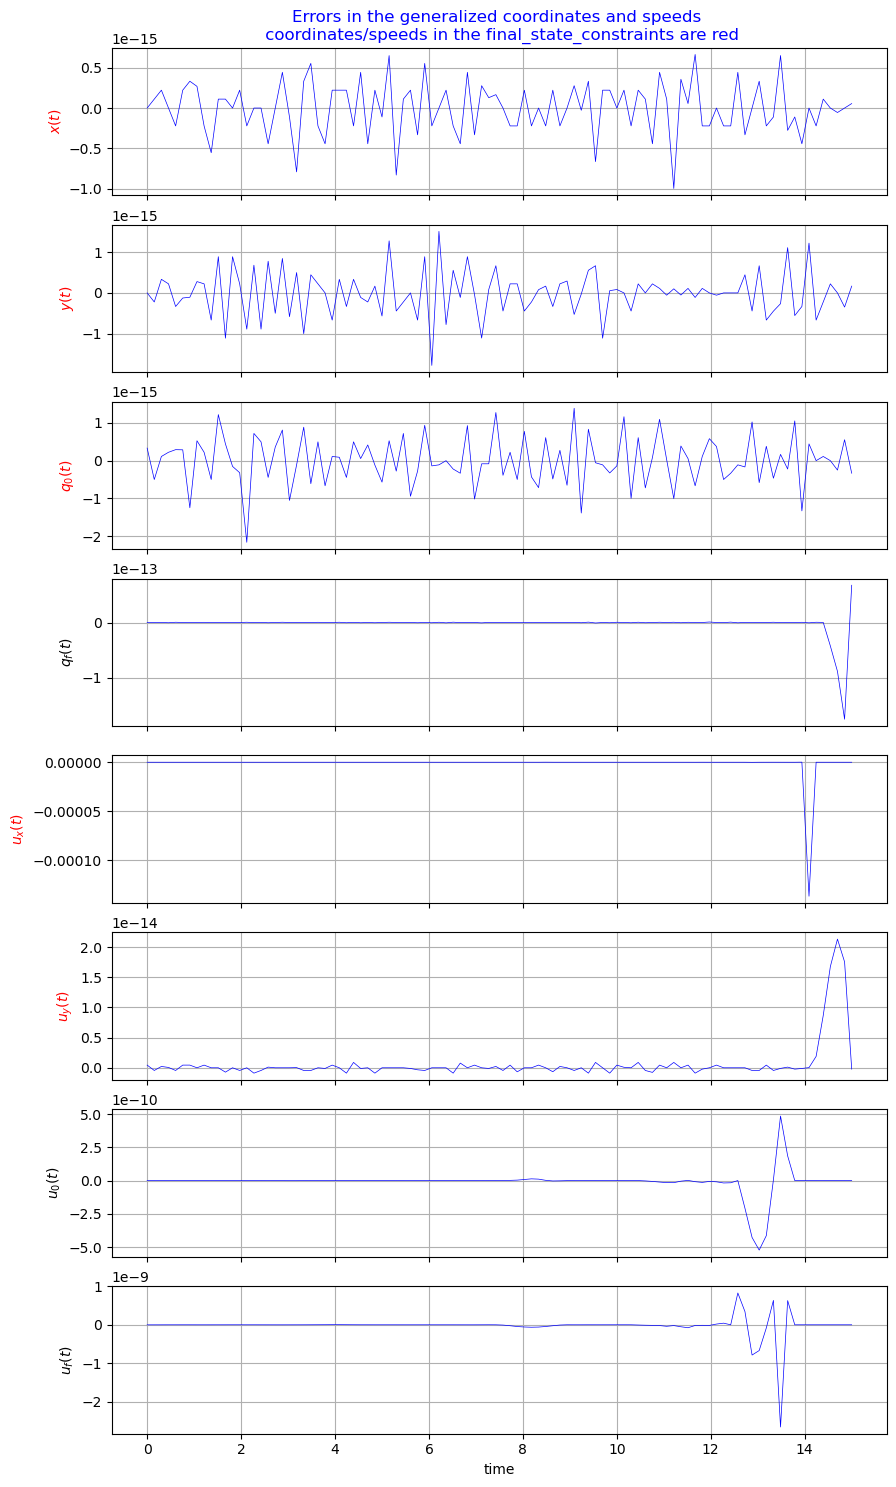

In [ ]:
welche = 1
fehler = g_list[welche]
anzahl = len(state_symbols)
fig, ax = plt.subplots(anzahl, 1, figsize=(10, 2.25*anzahl), sharex=True)
times = np.linspace(0.0, duration, num=num_nodes)

for i, j in enumerate(state_symbols):
    if j in final_state_constraints.keys():
        farbe1 = 'red'
    else:
        farbe1 = 'black'

    if i < laenge:
        farbe = 'b'
    else:
        farbe = 'r'
    ax[i].plot(times, fehler[i * num_nodes:(i + 1) * num_nodes], color = farbe, lw=0.5)
    ax[i].grid()
    ax[i].set_ylabel(f'${str(j)}$', color=farbe1)
ax[-1].set_xlabel('time')
ax[0]. set_title(f'Errors in the generalized coordinates and speeds \n coordinates/speeds in the final_state_constraints are red', color = 'b');
print(
     f'error in the final state constraints x:  {fehler[-5]:.3e},\n error in the final state constrains ux: {fehler[-4]:.3e} \n' +
     f'error in the final state constraints y:  {fehler[-3]:.3e},\n error in the final state constrains uy: {fehler[-2]:.3e} \n' +
     f'error in the final state constraints q0: {fehler[-1]:.3e}'
    )


Plot generalized coordinates / speeds and forces / torques

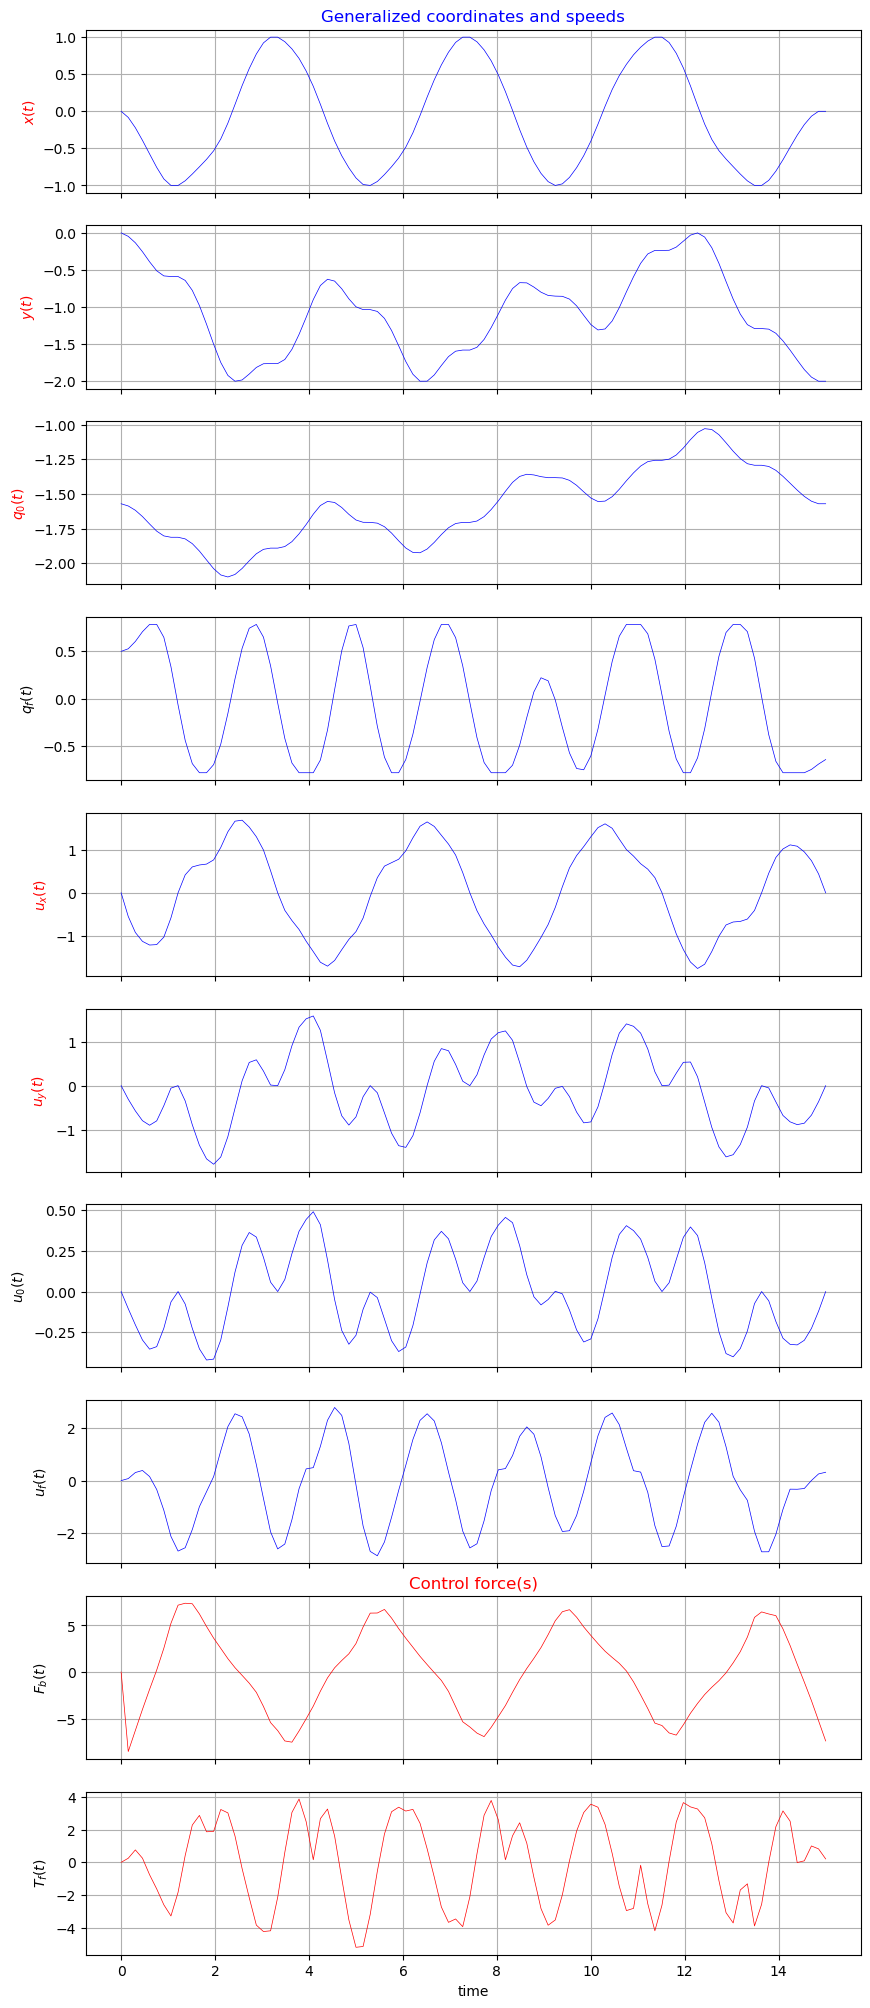

In [6]:
solution = solution_list[welche]
anzahl = len(state_symbols) + len(specified_symbols)
fig, ax = plt.subplots(anzahl, 1, figsize=(10, 2.5*anzahl), sharex=True)
times = np.linspace(0.0, duration, num=num_nodes)

for i, j in enumerate(state_symbols + specified_symbols):
    if j in final_state_constraints.keys():
        farbe1 = 'red'
    else:
        farbe1 = 'black'

    if i < laenge:
        farbe = 'b'
    else:
        farbe = 'r'
    ax[i].plot(times, solution[i * num_nodes:(i + 1) * num_nodes], color = farbe, lw = 0.5)
    ax[i].grid()
    ax[i].set_ylabel(f'${str(j)}$', color=farbe1)
ax[-1].set_xlabel('time')
ax[0]. set_title('Generalized coordinates and speeds', color = 'b')
ax[laenge]. set_title('Control force(s)', color = 'r');

aminate the **car**\
Nothing special, just a lot of points have to be set, this is why it looks so large.\
The green arrows symbolize the forces which opty calculated to drive the car. They are perpendicular to the rear axle - \
after all, it is rear wheel drive

In [ ]:
fps = 30

def add_point_to_data(line, x, y):
# to trace the path of the point. Copied from Timo.
    old_x, old_y = line.get_data()
    line.set_data(np.append(old_x, x), np.append(old_y, y))


state_vals, input_vals, _ = parse_free(solution, len(state_symbols), len(specified_symbols), num_nodes)
t_arr = np.linspace(t0, tf, num_nodes)
state_sol = CubicSpline(t_arr, state_vals.T)
input_sol = CubicSpline(t_arr, input_vals.T)

# create additional points for the axles
Pbl, Pbr, Pfl, Pfr = sm.symbols('Pbl Pbr Pfl Pfr', cls= me.Point)
Fbq = me.Point('Fbq')                                      # end points of the force
la = sm.symbols('la')                                                               # length of the axles
fb, tq = sm.symbols('f_b, t_q')                                                      # forces at the axles

Pbl.set_pos(Pb, -la/2 * Ab.x)
Pbr.set_pos(Pb, la/2 * Ab.x)
Pfl.set_pos(Pf, -la/2 * Af.x)
Pfr.set_pos(Pf, la/2 * Af.x)

Fbq.set_pos(Pb, fb * Ab.y)

coordinates = Pb.pos_from(O).to_matrix(N)
for point in (Dmc, Pf, Pbl, Pbr, Pfl, Pfr, Fbq):
    coordinates = coordinates.row_join(point.pos_from(O).to_matrix(N))

pL, pL_vals = zip(*par_map.items())
la1 = par_map[l] / 4.                      # length of an axle
coords_lam = sm.lambdify((*state_symbols, fb, tq, *pL, la), coordinates, cse=True)


# needed to give the picture the right size.
xmin, xmax = -5, 5.
ymin, ymax = -5., 5.

fig = plt.figure(figsize=(9, 9))
ax  = fig.add_subplot(111)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
ax.grid()
ax.plot(initial_state_constraints[x], initial_state_constraints[y], 'ro', markersize=10)                        # the initial position
ax.plot(final_state_constraints[x], final_state_constraints[y], 'go', markersize=10)                            # the final position

ax.axvline(bounds[x][1]+0.1, color='red', lw=0.5)
ax.axvline(bounds[x][0] - par_map[l]-0.1, color='red', lw=0.5)

# Initialize the block
line1, = ax.plot([], [], color='orange', lw=2)                                                                  # the car
line2, = ax.plot([], [], color='red', lw=2)                                                                     # the back axle
line3, = ax.plot([], [], color='magenta', lw=2)                                                                 # the front axle
line4  = ax.quiver([], [], [], [], color='green', scale=35, width=0.004, headwidth=8)                           # the force at the back axle
line5, = ax.plot([], [], color='black', lw=0.5)                                                                 # trace the front left wheel
line6, = ax.plot([], [], color='black', lw=0.5)                                                                 # trace the front right wheel

# Function to update the plot for each animation frame
def update(t):
    message = (f'running time {t:.2f} sec \n The back axle is red, the front axle is magenta \n The driving force is green')
    ax.set_title(message, fontsize=12)

    coords = coords_lam(*state_sol(t), *input_sol(t), *pL_vals, la1)

#   Pb, Dmc, Pf, Pbl, Pbr, Pfl, Pfr, Fbq                                      sequence of points in coords.
    line1.set_data([coords[0, 0], coords[0, 2]], [coords[1, 0], coords[1, 2]])
    line2.set_data([coords[0, 3], coords[0, 4]], [coords[1, 3], coords[1, 4]])
    line3.set_data([coords[0, 5], coords[0, 6]], [coords[1, 5], coords[1, 6]])

    line4.set_offsets([coords[0, 0], coords[1, 0]])
    line4.set_UVC(coords[0, 7] - coords[0, 0] , coords[1, 7] - coords[1, 0])

    add_point_to_data(line5, coords[0, 5], coords[1, 5])
    add_point_to_data(line6, coords[0, 6], coords[1, 6])

    return line1, line2, line3, line4, line5, line6,

# Set labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Create the animation
animation = FuncAnimation(fig, update, frames=np.arange(t0, tf, 1 / fps), interval=fps, blit=False)
plt.close(fig)  # Prevents the final image from being displayed directly below the animation
# Show the plot
display(HTML(animation.to_jshtml()))
print(f'it took {time.time()-start:.1f} seconds to run the code.')